In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats
import pandas_profiling 

import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

import statsmodels.formula.api as sm


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

from sklearn.metrics import roc_curve, auc


In [3]:
### Notebook configuration settings
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 1000
pd.options.display.float_format = '{:.3f}'.format
import warnings
warnings.filterwarnings('ignore')

In [4]:
writer=pd.ExcelWriter('network_intrusion_multinomial_clsfn.xlsx', engine='xlsxwriter')

### Importing network train and test file

In [5]:
### Train file
network_train=pd.read_csv('NSL_Dataset\Train.txt',sep=',',header=None)

In [6]:
### Test file
network_test=pd.read_csv('NSL_Dataset\Test.txt',sep=',',header=None)

In [7]:
BASIC_FEATURES=['DURATION','PROTOCOL_TYPE','SERVICE','FLAG','SRC_BYTES','DST_BYTES','LAND','WRONG_FRAGMENT','URGENT']

In [8]:
CONTENT_FEATURES =['HOT','NUM_FAILED_LOGINS','LOGGED_IN','NUM_COMPROMISED','ROOT_SHELL','SU_ATTEMPTED','NUM_ROOT','NUM_FILE_CREATIONS','NUM_SHELLS','NUM_ACCESS_FILES','NUM_OUTBOUND_CMDS','IS_HOST_LOGIN','IS_GUEST_LOGIN']

In [9]:
TIME_FEATURES=['COUNT','SRV_COUNT','SERROR_RATE','SRV_SERROR_RATE','RERROR_RATE','SRV_RERROR_RATE','SAME_SRV_RATE','DIFF_SRV_RATE','SRV_DIFF_HOST_RATE']

In [10]:
HOST_FEATURES=['DST_HOST_COUNT','DST_HOST_SRV_COUNT','DST_HOST_SAME_SRV_RATE','DST_HOST_DIFF_SRV_RATE','DST_HOST_SAME_SRC_PORT_RATE','DST_HOST_SRV_DIFF_HOST_RATE','DST_HOST_SERROR_RATE','DST_HOST_SRV_SERROR_RATE','DST_HOST_RERROR_RATE','DST_HOST_SRV_RERROR_RATE']

In [11]:
OTHER_FEATURES=['ATTACK','LAST_FLAG']

In [12]:
total_features=BASIC_FEATURES+CONTENT_FEATURES+TIME_FEATURES+HOST_FEATURES+OTHER_FEATURES

In [13]:
network_train.columns=total_features

In [14]:
network_test.columns=total_features

### Train and test dataset structure

In [15]:
network_train.shape

(125973, 43)

In [16]:
network_train.head()

,DURATION,PROTOCOL_TYPE,SERVICE,FLAG,SRC_BYTES,DST_BYTES,LAND,WRONG_FRAGMENT,URGENT,HOT,NUM_FAILED_LOGINS,LOGGED_IN,NUM_COMPROMISED,ROOT_SHELL,SU_ATTEMPTED,NUM_ROOT,NUM_FILE_CREATIONS,NUM_SHELLS,NUM_ACCESS_FILES,NUM_OUTBOUND_CMDS,IS_HOST_LOGIN,IS_GUEST_LOGIN,COUNT,SRV_COUNT,SERROR_RATE,SRV_SERROR_RATE,RERROR_RATE,SRV_RERROR_RATE,SAME_SRV_RATE,DIFF_SRV_RATE,SRV_DIFF_HOST_RATE,DST_HOST_COUNT,DST_HOST_SRV_COUNT,DST_HOST_SAME_SRV_RATE,DST_HOST_DIFF_SRV_RATE,DST_HOST_SAME_SRC_PORT_RATE,DST_HOST_SRV_DIFF_HOST_RATE,DST_HOST_SERROR_RATE,DST_HOST_SRV_SERROR_RATE,DST_HOST_RERROR_RATE,DST_HOST_SRV_RERROR_RATE,ATTACK,LAST_FLAG
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.000,0.000,0.000,0.000,1.000,0.000,0.000,150,25,0.170,0.030,0.170,0.000,0.000,0.000,0.050,0.000,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.000,0.000,0.000,0.000,0.080,0.150,0.000,255,1,0.000,0.600,0.880,0.000,0.000,0.000,0.000,0.000,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.000,1.000,0.000,0.000,0.050,0.070,0.000,255,26,0.100,0.050,0.000,0.000,1.000,1.000,0.000,0.000,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.200,0.200,0.000,0.000,1.000,0.000,0.000,30,255,1.000,0.000,0.030,0.040,0.030,0.010,0.000,0.010,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.000,0.000,0.000,0.000,1.000,0.000,0.090,255,255,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,normal,21


In [17]:
network_test.shape

(22544, 43)

In [18]:
network_test.head()

,DURATION,PROTOCOL_TYPE,SERVICE,FLAG,SRC_BYTES,DST_BYTES,LAND,WRONG_FRAGMENT,URGENT,HOT,NUM_FAILED_LOGINS,LOGGED_IN,NUM_COMPROMISED,ROOT_SHELL,SU_ATTEMPTED,NUM_ROOT,NUM_FILE_CREATIONS,NUM_SHELLS,NUM_ACCESS_FILES,NUM_OUTBOUND_CMDS,IS_HOST_LOGIN,IS_GUEST_LOGIN,COUNT,SRV_COUNT,SERROR_RATE,SRV_SERROR_RATE,RERROR_RATE,SRV_RERROR_RATE,SAME_SRV_RATE,DIFF_SRV_RATE,SRV_DIFF_HOST_RATE,DST_HOST_COUNT,DST_HOST_SRV_COUNT,DST_HOST_SAME_SRV_RATE,DST_HOST_DIFF_SRV_RATE,DST_HOST_SAME_SRC_PORT_RATE,DST_HOST_SRV_DIFF_HOST_RATE,DST_HOST_SERROR_RATE,DST_HOST_SRV_SERROR_RATE,DST_HOST_RERROR_RATE,DST_HOST_SRV_RERROR_RATE,ATTACK,LAST_FLAG
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.000,0.000,1.000,1.000,0.040,0.060,0.000,255,10,0.040,0.060,0.000,0.000,0.000,0.000,1.000,1.000,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.000,0.000,1.000,1.000,0.010,0.060,0.000,255,1,0.000,0.060,0.000,0.000,0.000,0.000,1.000,1.000,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.000,0.000,0.000,0.000,1.000,0.000,0.000,134,86,0.610,0.040,0.610,0.020,0.000,0.000,0.000,0.000,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.000,0.000,0.000,0.000,1.000,0.000,1.000,3,57,1.000,0.000,1.000,0.280,0.000,0.000,0.000,0.000,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.000,0.120,1.000,0.500,1.000,0.000,0.750,29,86,0.310,0.170,0.030,0.020,0.000,0.000,0.830,0.710,mscan,11


### Check categorical columns to have equal number of categories in both train and test dataset

In [19]:
### Train dataset
for col in network_train.columns:
    if network_train[col].dtypes == 'object' :
        print(f"Number of categories in {col} : {network_train[col].nunique()}")

Number of categories in PROTOCOL_TYPE : 3
Number of categories in SERVICE : 70
Number of categories in FLAG : 11
Number of categories in ATTACK : 23


In [ ]:
### Test dataset

In [20]:
for col in network_test.columns:
    if network_test[col].dtypes == 'object' :
        print(f"Number of categories in {col} : {network_test[col].nunique()}")

Number of categories in PROTOCOL_TYPE : 3
Number of categories in SERVICE : 64
Number of categories in FLAG : 11
Number of categories in ATTACK : 38


- As we have observed that SERVICE column has 6 missing categories in test dataset.We will include this categories while creating dummy variables

In [21]:
missing_cols=list(set(network_train['SERVICE'])-set(network_test['SERVICE']))

### Creation of user defined functions

In [22]:
## function to remove column from categorical and numerical features
def remove_columns_from_list(categorical,numerical,col):
    if col in categorical:
        categorical.remove(col)
    elif col in numerical:
        numerical.remove(col)
    else:
        print("Variable not present in both the list")
        
    return categorical,numerical
    

In [23]:
def remove_columns_from_main_set(network_data,col):
    network_data.drop(col,axis=1,inplace=True)
    
    

In [24]:
def missing_treatment(network_data,col):
    if col in categorical:
        network_data[col].fillna(network_data[col].mode()[0],inplace=True)
    elif col in numerical:
        network_data[col].fillna(network_data[col].median(),inplace=True)
    else:
        print("Variable not present in both the list")
    
        
    

In [25]:
def cont_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), round(x.sum(),2), round(x.mean(),2), round(x.median(),2),  round(x.std(),2), round(x.var(),2), round((x.std()/x.mean()),2), round(x.min(),2), round(x.dropna().quantile(0.01),2), round(x.dropna().quantile(0.05),2),round(x.dropna().quantile(0.10),2),round(x.dropna().quantile(0.25),2),round(x.dropna().quantile(0.50),2),round(x.dropna().quantile(0.75),2), round(x.dropna().quantile(0.90),2),round(x.dropna().quantile(0.95),2), round(x.dropna().quantile(0.99),2),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'CV','MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

def cat_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [26]:
dummy_var=[]
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    for col1 in col_dummies:
         dummy_var.append(col1)
    return df


### Numerical and categorical variables

#### Train data

In [27]:

numerical_train=[key for key in dict(network_train.dtypes) if dict(network_train.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
categorical_train=[key for key in dict(network_train.dtypes) if dict(network_train.dtypes)[key] in ['object']]
print(f"Numerical variables : \n \n {numerical_train} \n")
print(f"Categorical variables : \n \n {categorical_train} \n")
print(f"Number of Numerical variables : \n \n {len(numerical_train)} \n")
print(f"Number of Categorical variables : \n \n {len(categorical_train)} \n")

Numerical variables : 
 
 ['DURATION', 'SRC_BYTES', 'DST_BYTES', 'LAND', 'WRONG_FRAGMENT', 'URGENT', 'HOT', 'NUM_FAILED_LOGINS', 'LOGGED_IN', 'NUM_COMPROMISED', 'ROOT_SHELL', 'SU_ATTEMPTED', 'NUM_ROOT', 'NUM_FILE_CREATIONS', 'NUM_SHELLS', 'NUM_ACCESS_FILES', 'NUM_OUTBOUND_CMDS', 'IS_HOST_LOGIN', 'IS_GUEST_LOGIN', 'COUNT', 'SRV_COUNT', 'SERROR_RATE', 'SRV_SERROR_RATE', 'RERROR_RATE', 'SRV_RERROR_RATE', 'SAME_SRV_RATE', 'DIFF_SRV_RATE', 'SRV_DIFF_HOST_RATE', 'DST_HOST_COUNT', 'DST_HOST_SRV_COUNT', 'DST_HOST_SAME_SRV_RATE', 'DST_HOST_DIFF_SRV_RATE', 'DST_HOST_SAME_SRC_PORT_RATE', 'DST_HOST_SRV_DIFF_HOST_RATE', 'DST_HOST_SERROR_RATE', 'DST_HOST_SRV_SERROR_RATE', 'DST_HOST_RERROR_RATE', 'DST_HOST_SRV_RERROR_RATE', 'LAST_FLAG'] 

Categorical variables : 
 
 ['PROTOCOL_TYPE', 'SERVICE', 'FLAG', 'ATTACK'] 

Number of Numerical variables : 
 
 39 

Number of Categorical variables : 
 
 4 



#### Test data

In [28]:

numerical_test=[key for key in dict(network_test.dtypes) if dict(network_test.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
categorical_test=[key for key in dict(network_test.dtypes) if dict(network_test.dtypes)[key] in ['object']]
print(f"Numerical variables : \n \n {numerical_test} \n")
print(f"Categorical variables : \n \n {categorical_test} \n")

Numerical variables : 
 
 ['DURATION', 'SRC_BYTES', 'DST_BYTES', 'LAND', 'WRONG_FRAGMENT', 'URGENT', 'HOT', 'NUM_FAILED_LOGINS', 'LOGGED_IN', 'NUM_COMPROMISED', 'ROOT_SHELL', 'SU_ATTEMPTED', 'NUM_ROOT', 'NUM_FILE_CREATIONS', 'NUM_SHELLS', 'NUM_ACCESS_FILES', 'NUM_OUTBOUND_CMDS', 'IS_HOST_LOGIN', 'IS_GUEST_LOGIN', 'COUNT', 'SRV_COUNT', 'SERROR_RATE', 'SRV_SERROR_RATE', 'RERROR_RATE', 'SRV_RERROR_RATE', 'SAME_SRV_RATE', 'DIFF_SRV_RATE', 'SRV_DIFF_HOST_RATE', 'DST_HOST_COUNT', 'DST_HOST_SRV_COUNT', 'DST_HOST_SAME_SRV_RATE', 'DST_HOST_DIFF_SRV_RATE', 'DST_HOST_SAME_SRC_PORT_RATE', 'DST_HOST_SRV_DIFF_HOST_RATE', 'DST_HOST_SERROR_RATE', 'DST_HOST_SRV_SERROR_RATE', 'DST_HOST_RERROR_RATE', 'DST_HOST_SRV_RERROR_RATE', 'LAST_FLAG'] 

Categorical variables : 
 
 ['PROTOCOL_TYPE', 'SERVICE', 'FLAG', 'ATTACK'] 



### Creation of dummy variables

#### Train data

In [29]:
network_train.shape

(125973, 43)

In [30]:
for col in ['PROTOCOL_TYPE','SERVICE','FLAG']:
    network_train = create_dummies(network_train , col )

In [31]:
network_train.shape

(125973, 121)

In [32]:
network_train.head()

,DURATION,SRC_BYTES,DST_BYTES,LAND,WRONG_FRAGMENT,URGENT,HOT,NUM_FAILED_LOGINS,LOGGED_IN,NUM_COMPROMISED,ROOT_SHELL,SU_ATTEMPTED,NUM_ROOT,NUM_FILE_CREATIONS,NUM_SHELLS,NUM_ACCESS_FILES,NUM_OUTBOUND_CMDS,IS_HOST_LOGIN,IS_GUEST_LOGIN,COUNT,SRV_COUNT,SERROR_RATE,SRV_SERROR_RATE,RERROR_RATE,SRV_RERROR_RATE,SAME_SRV_RATE,DIFF_SRV_RATE,SRV_DIFF_HOST_RATE,DST_HOST_COUNT,DST_HOST_SRV_COUNT,DST_HOST_SAME_SRV_RATE,DST_HOST_DIFF_SRV_RATE,DST_HOST_SAME_SRC_PORT_RATE,DST_HOST_SRV_DIFF_HOST_RATE,DST_HOST_SERROR_RATE,DST_HOST_SRV_SERROR_RATE,DST_HOST_RERROR_RATE,DST_HOST_SRV_RERROR_RATE,ATTACK,LAST_FLAG,PROTOCOL_TYPE_tcp,PROTOCOL_TYPE_udp,SERVICE_X11,SERVICE_Z39_50,SERVICE_aol,SERVICE_auth,SERVICE_bgp,SERVICE_courier,SERVICE_csnet_ns,SERVICE_ctf,SERVICE_daytime,SERVICE_discard,SERVICE_domain,SERVICE_domain_u,SERVICE_echo,SERVICE_eco_i,SERVICE_ecr_i,SERVICE_efs,SERVICE_exec,SERVICE_finger,SERVICE_ftp,SERVICE_ftp_data,SERVICE_gopher,SERVICE_harvest,SERVICE_hostnames,SERVICE_http,SERVICE_http_2784,SERVICE_http_443,SERVICE_http_8001,SERVICE_imap4,SERVICE_iso_tsap,SERVICE_klogin,SERVICE_kshell,SERVICE_ldap,SERVICE_link,SERVICE_login,SERVICE_mtp,SERVICE_name,SERVICE_netbios_dgm,SERVICE_netbios_ns,SERVICE_netbios_ssn,SERVICE_netstat,SERVICE_nnsp,SERVICE_nntp,SERVICE_ntp_u,SERVICE_other,SERVICE_pm_dump,SERVICE_pop_2,SERVICE_pop_3,SERVICE_printer,SERVICE_private,SERVICE_red_i,SERVICE_remote_job,SERVICE_rje,SERVICE_shell,SERVICE_smtp,SERVICE_sql_net,SERVICE_ssh,SERVICE_sunrpc,SERVICE_supdup,SERVICE_systat,SERVICE_telnet,SERVICE_tftp_u,SERVICE_tim_i,SERVICE_time,SERVICE_urh_i,SERVICE_urp_i,SERVICE_uucp,SERVICE_uucp_path,SERVICE_vmnet,SERVICE_whois,FLAG_REJ,FLAG_RSTO,FLAG_RSTOS0,FLAG_RSTR,FLAG_S0,FLAG_S1,FLAG_S2,FLAG_S3,FLAG_SF,FLAG_SH
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.000,0.000,0.000,0.000,1.000,0.000,0.000,150,25,0.170,0.030,0.170,0.000,0.000,0.000,0.050,0.000,normal,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.000,0.000,0.000,0.000,0.080,0.150,0.000,255,1,0.000,0.600,0.880,0.000,0.000,0.000,0.000,0.000,normal,15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.000,1.000,0.000,0.000,0.050,0.070,0.000,255,26,0.100,0.050,0.000,0.000,1.000,1.000,0.000,0.000,neptune,19,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.200,0.200,0.000,0.000,1.000,0.000,0.000,30,255,1.000,0.000,0.030,0.040,0.030,0.010,0.000,0.010,normal,21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.000,0.000,0.000,0.000,1.000,0.000,0.090,255,255,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,normal,21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


#### Test data

In [33]:

dummy_miss_list=[]
dummy_miss_list=['SERVICE_' + col for col in missing_cols ]

In [34]:
dummy_miss_list

['SERVICE_http_2784',
 'SERVICE_aol',
 'SERVICE_red_i',
 'SERVICE_urh_i',
 'SERVICE_http_8001',
 'SERVICE_harvest']

In [35]:
network_test.shape

(22544, 43)

In [36]:
for col in ['PROTOCOL_TYPE','SERVICE','FLAG']:
    network_test = create_dummies(network_test , col )

In [37]:
network_test.shape

(22544, 115)

In [38]:
for col in dummy_miss_list:
    network_test[col]=0

In [39]:
network_test.shape

(22544, 121)

In [40]:
network_test.head()

,DURATION,SRC_BYTES,DST_BYTES,LAND,WRONG_FRAGMENT,URGENT,HOT,NUM_FAILED_LOGINS,LOGGED_IN,NUM_COMPROMISED,ROOT_SHELL,SU_ATTEMPTED,NUM_ROOT,NUM_FILE_CREATIONS,NUM_SHELLS,NUM_ACCESS_FILES,NUM_OUTBOUND_CMDS,IS_HOST_LOGIN,IS_GUEST_LOGIN,COUNT,SRV_COUNT,SERROR_RATE,SRV_SERROR_RATE,RERROR_RATE,SRV_RERROR_RATE,SAME_SRV_RATE,DIFF_SRV_RATE,SRV_DIFF_HOST_RATE,DST_HOST_COUNT,DST_HOST_SRV_COUNT,DST_HOST_SAME_SRV_RATE,DST_HOST_DIFF_SRV_RATE,DST_HOST_SAME_SRC_PORT_RATE,DST_HOST_SRV_DIFF_HOST_RATE,DST_HOST_SERROR_RATE,DST_HOST_SRV_SERROR_RATE,DST_HOST_RERROR_RATE,DST_HOST_SRV_RERROR_RATE,ATTACK,LAST_FLAG,PROTOCOL_TYPE_tcp,PROTOCOL_TYPE_udp,SERVICE_X11,SERVICE_Z39_50,SERVICE_auth,SERVICE_bgp,SERVICE_courier,SERVICE_csnet_ns,SERVICE_ctf,SERVICE_daytime,SERVICE_discard,SERVICE_domain,SERVICE_domain_u,SERVICE_echo,SERVICE_eco_i,SERVICE_ecr_i,SERVICE_efs,SERVICE_exec,SERVICE_finger,SERVICE_ftp,SERVICE_ftp_data,SERVICE_gopher,SERVICE_hostnames,SERVICE_http,SERVICE_http_443,SERVICE_imap4,SERVICE_iso_tsap,SERVICE_klogin,SERVICE_kshell,SERVICE_ldap,SERVICE_link,SERVICE_login,SERVICE_mtp,SERVICE_name,SERVICE_netbios_dgm,SERVICE_netbios_ns,SERVICE_netbios_ssn,SERVICE_netstat,SERVICE_nnsp,SERVICE_nntp,SERVICE_ntp_u,SERVICE_other,SERVICE_pm_dump,SERVICE_pop_2,SERVICE_pop_3,SERVICE_printer,SERVICE_private,SERVICE_remote_job,SERVICE_rje,SERVICE_shell,SERVICE_smtp,SERVICE_sql_net,SERVICE_ssh,SERVICE_sunrpc,SERVICE_supdup,SERVICE_systat,SERVICE_telnet,SERVICE_tftp_u,SERVICE_tim_i,SERVICE_time,SERVICE_urp_i,SERVICE_uucp,SERVICE_uucp_path,SERVICE_vmnet,SERVICE_whois,FLAG_REJ,FLAG_RSTO,FLAG_RSTOS0,FLAG_RSTR,FLAG_S0,FLAG_S1,FLAG_S2,FLAG_S3,FLAG_SF,FLAG_SH,SERVICE_http_2784,SERVICE_aol,SERVICE_red_i,SERVICE_urh_i,SERVICE_http_8001,SERVICE_harvest
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.000,0.000,1.000,1.000,0.040,0.060,0.000,255,10,0.040,0.060,0.000,0.000,0.000,0.000,1.000,1.000,neptune,21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.000,0.000,1.000,1.000,0.010,0.060,0.000,255,1,0.000,0.060,0.000,0.000,0.000,0.000,1.000,1.000,neptune,21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.000,0.000,0.000,0.000,1.000,0.000,0.000,134,86,0.610,0.040,0.610,0.020,0.000,0.000,0.000,0.000,normal,21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.000,0.000,0.000,0.000,1.000,0.000,1.000,3,57,1.000,0.000,1.000,0.280,0.000,0.000,0.000,0.000,saint,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.000,0.120,1.000,0.500,1.000,0.000,0.750,29,86,0.310,0.170,0.030,0.020,0.000,0.000,0.830,0.710,mscan,11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Categorization of ATTACK into following 4 attack class

- DOS
- PROBE
- R2L
- U2R

In [41]:
DOS=['back','land','neptune','pod','smurf','teardrop','apache2','udpstorm','processtable','worm']
PROBE=['satan','ipsweep','nmap','portsweep','mscan','saint']
R2L=['guess_passwd','ftp_write','imap','phf','multihop','warezmaster','warezclient','spy','xlock','xsnoop','snmpguess','snmpgetattack','httptunnel','sendmail','named']
U2R=['buffer_overflow','loadmodule','rootkit','perl','sqlattack','xterm','ps']

#### Train data

In [42]:
network_train['ATTACKTYPE']=np.where(
    network_train['ATTACK'].isin(DOS),'DOS',
    np.where(network_train['ATTACK'].isin(PROBE),'PROBE',
    np.where(network_train['ATTACK'].isin(R2L),'R2L',
    np.where(network_train['ATTACK'].isin(U2R),'U2R','NORMAL'
            )
            )
            )
)

In [43]:
network_train['ATTACKTYPE'].value_counts()

NORMAL    67343
DOS       45927
PROBE     11656
R2L         995
U2R          52
Name: ATTACKTYPE, dtype: int64

#### Test data

In [44]:
network_test['ATTACKTYPE']=np.where(
    network_test['ATTACK'].isin(DOS),'DOS',
    np.where(network_test['ATTACK'].isin(PROBE),'PROBE',
    np.where(network_test['ATTACK'].isin(R2L),'R2L',
    np.where(network_test['ATTACK'].isin(U2R),'U2R','NORMAL'
            )
            )
            )
)

In [45]:
network_test['ATTACKTYPE'].value_counts()

NORMAL    10004
DOS        7167
R2L        2885
PROBE      2421
U2R          67
Name: ATTACKTYPE, dtype: int64

### Distribution of network data based on 'DOS','PROBE','R2L','U2R','NORMAL'

#### Train data

In [46]:
network_train_dos=network_train[network_train['ATTACKTYPE'].isin(['NORMAL','DOS'])]

In [47]:
network_train_dos.shape

(113270, 122)

In [48]:
network_train_probe=network_train[network_train['ATTACKTYPE'].isin(['NORMAL','PROBE'])]

In [49]:
network_train_probe.shape

(78999, 122)

In [50]:
network_train_r2l=network_train[network_train['ATTACKTYPE'].isin(['NORMAL','R2L'])]

In [51]:
network_train_r2l.shape

(68338, 122)

In [52]:
network_train_u2r=network_train[network_train['ATTACKTYPE'].isin(['NORMAL','U2R'])]

In [53]:
network_train_u2r.shape

(67395, 122)

#### Test data

In [54]:
network_test_dos=network_test[network_test['ATTACKTYPE'].isin(['NORMAL','DOS'])]

In [55]:
network_test_dos.shape

(17171, 122)

In [56]:
network_test_probe=network_test[network_test['ATTACKTYPE'].isin(['NORMAL','PROBE'])]

In [57]:
network_test_probe.shape

(12425, 122)

In [58]:
network_test_r2l=network_test[network_test['ATTACKTYPE'].isin(['NORMAL','R2L'])]

In [59]:
network_test_r2l.shape

(12889, 122)

In [60]:
network_test_u2r=network_test[network_test['ATTACKTYPE'].isin(['NORMAL','U2R'])]

In [61]:
network_test_u2r.shape

(10071, 122)

### Creation of dependent binary variable of ATTACKTYPE column

#### Train

In [62]:
network_train_dos['ATTACK_BINARY']=np.where(network_train_dos['ATTACKTYPE']=='NORMAL',0,1)

In [63]:
network_train_dos['ATTACK_BINARY'].value_counts()

0    67343
1    45927
Name: ATTACK_BINARY, dtype: int64

In [64]:
network_train_probe['ATTACK_BINARY']=np.where(network_train_probe['ATTACKTYPE']=='NORMAL',0,1)

In [65]:
network_train_probe['ATTACK_BINARY'].value_counts()

0    67343
1    11656
Name: ATTACK_BINARY, dtype: int64

In [66]:
network_train_r2l['ATTACK_BINARY']=np.where(network_train_r2l['ATTACKTYPE']=='NORMAL',0,1)

In [67]:
network_train_r2l['ATTACK_BINARY'].value_counts()

0    67343
1      995
Name: ATTACK_BINARY, dtype: int64

In [68]:
network_train_u2r['ATTACK_BINARY']=np.where(network_train_u2r['ATTACKTYPE']=='NORMAL',0,1)

In [69]:
network_train_u2r['ATTACK_BINARY'].value_counts()

0    67343
1       52
Name: ATTACK_BINARY, dtype: int64

#### Test

In [70]:
network_test_dos['ATTACK_BINARY']=np.where(network_test_dos['ATTACKTYPE']=='NORMAL',0,1)

In [71]:
network_test_dos['ATTACK_BINARY'].value_counts()

0    10004
1     7167
Name: ATTACK_BINARY, dtype: int64

In [72]:
network_test_probe['ATTACK_BINARY']=np.where(network_test_probe['ATTACKTYPE']=='NORMAL',0,1)

In [73]:
network_test_probe['ATTACK_BINARY'].value_counts()

0    10004
1     2421
Name: ATTACK_BINARY, dtype: int64

In [74]:
network_test_r2l['ATTACK_BINARY']=np.where(network_test_r2l['ATTACKTYPE']=='NORMAL',0,1)

In [75]:
network_test_r2l['ATTACK_BINARY'].value_counts()

0    10004
1     2885
Name: ATTACK_BINARY, dtype: int64

In [76]:
network_test_u2r['ATTACK_BINARY']=np.where(network_test_u2r['ATTACKTYPE']=='NORMAL',0,1)

In [77]:
network_test_u2r['ATTACK_BINARY'].value_counts()

0    10004
1       67
Name: ATTACK_BINARY, dtype: int64

### Removing ATTACK AND ATTACKTYPE duplicate columns

#### Train

In [78]:
network_train.shape

(125973, 122)

In [79]:
network_train_dos.shape

(113270, 123)

In [80]:
network_train_probe.shape

(78999, 123)

In [81]:
network_train_r2l.shape

(68338, 123)

In [82]:
network_train_u2r.shape

(67395, 123)

In [83]:
network_train_dos1 = network_train_dos.drop(columns=['ATTACK','ATTACKTYPE'],axis=1)

In [84]:
network_train_dos1.shape

(113270, 121)

In [85]:
network_train_probe1 = network_train_probe.drop(columns=['ATTACK','ATTACKTYPE'],axis=1)

In [86]:
network_train_probe1.shape

(78999, 121)

In [87]:
network_train_r2l1 = network_train_r2l.drop(columns=['ATTACK','ATTACKTYPE'],axis=1)

In [88]:
network_train_r2l1.shape

(68338, 121)

In [89]:
network_train_u2r1 = network_train_u2r.drop(columns=['ATTACK','ATTACKTYPE'],axis=1)

In [90]:
network_train_u2r1.shape

(67395, 121)

#### Test

In [91]:
network_test.shape

(22544, 122)

In [92]:
network_test_dos.shape

(17171, 123)

In [93]:
network_test_probe.shape

(12425, 123)

In [94]:
network_test_r2l.shape

(12889, 123)

In [95]:
network_test_u2r.shape

(10071, 123)

In [96]:
network_test_dos1 = network_test_dos.drop(columns=['ATTACK','ATTACKTYPE'],axis=1)

In [97]:
network_test_dos1.shape

(17171, 121)

In [98]:
network_test_probe1 = network_test_probe.drop(columns=['ATTACK','ATTACKTYPE'],axis=1)

In [99]:
network_test_probe1.shape

(12425, 121)

In [100]:
network_test_r2l1 = network_test_r2l.drop(columns=['ATTACK','ATTACKTYPE'],axis=1)

In [101]:
network_test_r2l1.shape

(12889, 121)

In [102]:
network_test_u2r1 = network_test_u2r.drop(columns=['ATTACK','ATTACKTYPE'],axis=1)

In [103]:
network_test_u2r1.shape

(10071, 121)

### Separation of variables into independent and dependent variables

#### Train

In [104]:
network_train_dos1_X=network_train_dos1[network_train_dos1.columns.difference(['ATTACK_BINARY']).tolist()]

In [105]:
network_train_dos1_X.shape

(113270, 120)

In [106]:
network_train_dos1_Y=network_train_dos1['ATTACK_BINARY']

In [107]:
network_train_dos1_Y.shape

(113270,)

In [108]:
network_train_probe1_X=network_train_probe1[network_train_probe1.columns.difference(['ATTACK_BINARY']).tolist()]

In [109]:
network_train_probe1_X.shape

(78999, 120)

In [110]:
network_train_probe1_Y=network_train_probe1['ATTACK_BINARY']

In [111]:
network_train_probe1_Y.shape

(78999,)

In [112]:
network_train_r2l1_X=network_train_r2l1[network_train_r2l1.columns.difference(['ATTACK_BINARY']).tolist()]

In [113]:
network_train_r2l1_X.shape

(68338, 120)

In [114]:
network_train_r2l1_Y=network_train_r2l1['ATTACK_BINARY']

In [115]:
network_train_r2l1_Y.shape

(68338,)

In [116]:
network_train_u2r1_X=network_train_u2r1[network_train_u2r1.columns.difference(['ATTACK_BINARY']).tolist()]

In [117]:
network_train_u2r1_X.shape

(67395, 120)

In [118]:
network_train_u2r1_Y=network_train_u2r1['ATTACK_BINARY']

In [119]:
network_train_u2r1_Y.shape

(67395,)

### Resampling of U2R cases

In [120]:
from sklearn.utils import resample

In [121]:
network_train_u2r1['ATTACK_BINARY'].value_counts()/network_train_u2r1['ATTACK_BINARY'].count()

0   0.999
1   0.001
Name: ATTACK_BINARY, dtype: float64

In [122]:
df_majority_u2r = network_train_u2r1[network_train_u2r1['ATTACK_BINARY']==0]
df_minority_u2r = network_train_u2r1[network_train_u2r1['ATTACK_BINARY']==1]

In [123]:
df_majority_u2r['ATTACK_BINARY'].count()

67343

In [124]:
df_minority_u2r['ATTACK_BINARY'].count()

52

In [125]:
# Upsample minority class
df_minority_upsampled_u2r = resample(df_minority_u2r, 
                                 replace=True,     # sample with replacement
                                 n_samples=67343,    # to match majority class
                                 random_state=103) # reproducible results

In [126]:
df_minority_upsampled_u2r

,DURATION,SRC_BYTES,DST_BYTES,LAND,WRONG_FRAGMENT,URGENT,HOT,NUM_FAILED_LOGINS,LOGGED_IN,NUM_COMPROMISED,ROOT_SHELL,SU_ATTEMPTED,NUM_ROOT,NUM_FILE_CREATIONS,NUM_SHELLS,NUM_ACCESS_FILES,NUM_OUTBOUND_CMDS,IS_HOST_LOGIN,IS_GUEST_LOGIN,COUNT,SRV_COUNT,SERROR_RATE,SRV_SERROR_RATE,RERROR_RATE,SRV_RERROR_RATE,SAME_SRV_RATE,DIFF_SRV_RATE,SRV_DIFF_HOST_RATE,DST_HOST_COUNT,DST_HOST_SRV_COUNT,DST_HOST_SAME_SRV_RATE,DST_HOST_DIFF_SRV_RATE,DST_HOST_SAME_SRC_PORT_RATE,DST_HOST_SRV_DIFF_HOST_RATE,DST_HOST_SERROR_RATE,DST_HOST_SRV_SERROR_RATE,DST_HOST_RERROR_RATE,DST_HOST_SRV_RERROR_RATE,LAST_FLAG,PROTOCOL_TYPE_tcp,PROTOCOL_TYPE_udp,SERVICE_X11,SERVICE_Z39_50,SERVICE_aol,SERVICE_auth,SERVICE_bgp,SERVICE_courier,SERVICE_csnet_ns,SERVICE_ctf,SERVICE_daytime,SERVICE_discard,SERVICE_domain,SERVICE_domain_u,SERVICE_echo,SERVICE_eco_i,SERVICE_ecr_i,SERVICE_efs,SERVICE_exec,SERVICE_finger,SERVICE_ftp,SERVICE_ftp_data,SERVICE_gopher,SERVICE_harvest,SERVICE_hostnames,SERVICE_http,SERVICE_http_2784,SERVICE_http_443,SERVICE_http_8001,SERVICE_imap4,SERVICE_iso_tsap,SERVICE_klogin,SERVICE_kshell,SERVICE_ldap,SERVICE_link,SERVICE_login,SERVICE_mtp,SERVICE_name,SERVICE_netbios_dgm,SERVICE_netbios_ns,SERVICE_netbios_ssn,SERVICE_netstat,SERVICE_nnsp,SERVICE_nntp,SERVICE_ntp_u,SERVICE_other,SERVICE_pm_dump,SERVICE_pop_2,SERVICE_pop_3,SERVICE_printer,SERVICE_private,SERVICE_red_i,SERVICE_remote_job,SERVICE_rje,SERVICE_shell,SERVICE_smtp,SERVICE_sql_net,SERVICE_ssh,SERVICE_sunrpc,SERVICE_supdup,SERVICE_systat,SERVICE_telnet,SERVICE_tftp_u,SERVICE_tim_i,SERVICE_time,SERVICE_urh_i,SERVICE_urp_i,SERVICE_uucp,SERVICE_uucp_path,SERVICE_vmnet,SERVICE_whois,FLAG_REJ,FLAG_RSTO,FLAG_RSTOS0,FLAG_RSTR,FLAG_S0,FLAG_S1,FLAG_S2,FLAG_S3,FLAG_SF,FLAG_SH,ATTACK_BINARY
15931,169,1567,2857,0,0,0,3,0,1,4,1,0,0,1,0,0,0,0,0,1,1,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1,1,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
16983,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.000,0.000,0.000,0.000,1.000,0.000,0.000,2,2,1.000,0.000,0.500,0.000,0.000,0.000,0.000,0.000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
42396,321,1506,1887,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,151,1,0.990,0.000,0.010,1.000,0.010,0.060,0.000,6,6,1.000,0.000,0.170,0.000,0.000,0.000,0.170,0.170,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
65086,60,86,183,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0.000,0.000,0.000,0.000,1.000,0.000,0.000,255,1,0.000,0.020,0.000,0.000,0.000,0.000,0.000,0.000,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
15188,113,6274,16771,0,0,0,5,0,1,2,1,0,0,0,0,0,0,0,0,1,1,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1,1,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36730,150,1587,6707,0,0,0,1,0,1,3,0,0,1,1,0,0,0,0,0,1,1,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1,1,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [128]:
# Combine majority class with upsampled minority class
df_upsampled_u2r = pd.concat([df_majority_u2r, df_minority_upsampled_u2r])
 
# Display new class counts
df_upsampled_u2r['ATTACK_BINARY'].value_counts()

1    67343
0    67343
Name: ATTACK_BINARY, dtype: int64

In [129]:
network_train_u2r1_Y=network_train_u2r1['ATTACK_BINARY']

In [130]:
network_train_u2r1_Y.value_counts()

0    67343
1       52
Name: ATTACK_BINARY, dtype: int64

In [131]:
network_train_u2r1_Y=df_upsampled_u2r['ATTACK_BINARY']

In [132]:
network_train_u2r1_X=df_upsampled_u2r[df_upsampled_u2r.columns.difference(['ATTACK_BINARY']).tolist()]

In [133]:
network_train_u2r1_X.shape

(134686, 120)

#### Test

In [134]:
network_test_dos1_X=network_test_dos1[network_test_dos1.columns.difference(['ATTACK_BINARY']).tolist()]

In [135]:
network_test_dos1_X.shape

(17171, 120)

In [136]:
network_test_dos1_Y=network_test_dos1['ATTACK_BINARY']

In [137]:
network_test_dos1_Y.shape

(17171,)

In [138]:
network_test_probe1_X=network_test_probe1[network_test_probe1.columns.difference(['ATTACK_BINARY']).tolist()]

In [139]:
network_test_probe1_X.shape

(12425, 120)

In [140]:
network_test_probe1_Y=network_test_probe1['ATTACK_BINARY']

In [141]:
network_test_probe1_Y.shape

(12425,)

In [142]:
network_test_r2l1_X=network_test_r2l1[network_test_r2l1.columns.difference(['ATTACK_BINARY']).tolist()]

In [143]:
network_test_r2l1_X.shape

(12889, 120)

In [144]:
network_test_r2l1_Y=network_test_r2l1['ATTACK_BINARY']

In [145]:
network_test_r2l1_Y.shape

(12889,)

In [146]:
network_test_u2r1_X=network_test_u2r1[network_test_u2r1.columns.difference(['ATTACK_BINARY']).tolist()]

In [147]:
network_test_u2r1_X.shape

(10071, 120)

In [148]:
network_test_u2r1_Y=network_test_u2r1['ATTACK_BINARY']

In [149]:
network_test_u2r1_Y.shape

(10071,)

### Feature scaling of network train and test data

In [150]:
from sklearn import preprocessing

#### Train

In [151]:
dos1_X = preprocessing.StandardScaler().fit_transform(network_train_dos1_X)


In [152]:
dos1_X.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [153]:
probe1_X = preprocessing.StandardScaler().fit_transform(network_train_probe1_X)


In [154]:
r2l1_X = preprocessing.StandardScaler().fit_transform(network_train_r2l1_X)


In [155]:
u2r1_X = preprocessing.StandardScaler().fit_transform(network_train_u2r1_X)


#### Test

In [156]:
dos1_test_X = preprocessing.StandardScaler().fit_transform(network_test_dos1_X)


In [157]:
probe1_test_X = preprocessing.StandardScaler().fit_transform(network_test_probe1_X)


In [158]:
r2l1_test_X = preprocessing.StandardScaler().fit_transform(network_test_r2l1_X)


In [159]:
u2r1_test_X = preprocessing.StandardScaler().fit_transform(network_test_u2r1_X)


In [160]:
dos1_test_X.std()

0.9486832980505138

### Building Decision Tree Model

### DOS

In [161]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV

In [162]:
param_grid = {'max_depth': np.arange(3, 12),
             'max_features': np.arange(5,15)}

In [163]:
tree_dos = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5, scoring='roc_auc')
tree_dos.fit( dos1_X, network_train_dos1_Y )

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                         'max_features': array([ 5,  

In [191]:
dos1_X.shape

(113270, 120)

In [192]:
tree_dos.best_score_

0.999769523957926

In [193]:
tree_dos.best_params_

{'max_depth': 10, 'max_features': 10}

In [195]:
metrics.roc_auc_score(network_train_dos1_Y, pd.DataFrame(tree_dos.predict_proba(dos1_X))[1])

0.9995564866724421

In [200]:
train_pred_dos = tree_dos.predict(dos1_X)

In [201]:
train_pred_dos

array([0, 0, 1, ..., 0, 1, 0])

In [202]:
print(metrics.classification_report(network_train_dos1_Y, train_pred_dos))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     67343
           1       1.00      0.98      0.99     45927

    accuracy                           0.99    113270
   macro avg       0.99      0.99      0.99    113270
weighted avg       0.99      0.99      0.99    113270



In [203]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 15.0, 'Predicted label')

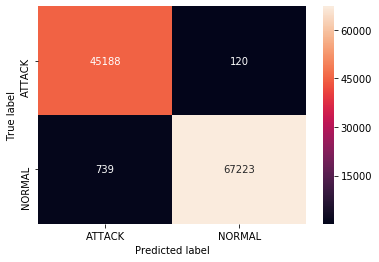

In [204]:
#plt.figure(1 , figsize = (10 , 5))
tree_cm_dos = metrics.confusion_matrix( train_pred_dos,
                                 network_train_dos1_Y,
                                 [1,0] )

sns.heatmap(tree_cm_dos, annot=True,
         fmt='.0f',
         xticklabels = ["ATTACK", "NORMAL"] , yticklabels = ["ATTACK", "NORMAL"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [205]:
clf_tree_dos = DecisionTreeClassifier( max_depth =10, max_features=10 )
clf_tree_dos.fit( dos1_X, network_train_dos1_Y )

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [206]:
clf_tree_dos.feature_importances_

array([6.96276886e-03, 2.80946300e-05, 5.87365817e-04, 5.46502567e-03,
       8.16923918e-04, 4.21087563e-04, 7.26584097e-05, 2.66296608e-03,
       1.63955120e-03, 1.94309323e-03, 3.04165355e-03, 1.88117460e-04,
       1.87297533e-05, 7.20590398e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.69888434e-03, 0.00000000e+00, 1.69627955e-07,
       0.00000000e+00, 0.00000000e+00, 1.08937240e-04, 0.00000000e+00,
       1.22876042e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.41879244e-03, 0.00000000e+00, 0.00000000e+00, 1.63156270e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.73943649e-05,
       0.00000000e+00, 5.35127514e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.02001302e-01, 4.72498289e-06, 0.00000000e+00,
       1.36473953e-10, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.75737324e-04, 0.00000000e+00,
      

In [208]:
var_imp_dos = pd.concat([pd.Series(network_train_dos1_X.columns), pd.Series(clf_tree_dos.feature_importances_)], axis=1)
var_imp_dos.columns = ['feature', 'importance']

In [210]:
var_imp_dos.sort_values('importance', ascending=False).iloc[0:10].reset_index(drop=True)

,feature,importance
0,SRC_BYTES,0.741
1,SAME_SRV_RATE,0.102
2,PROTOCOL_TYPE_tcp,0.054
3,WRONG_FRAGMENT,0.036
4,NUM_COMPROMISED,0.016
5,HOT,0.012
6,COUNT,0.007
7,DST_HOST_COUNT,0.005
8,SRV_SERROR_RATE,0.005
9,SERVICE_http,0.005


In [213]:
DOS_sel_features=var_imp_dos.sort_values('importance', ascending=False).iloc[0:10].reset_index(drop=True).feature.tolist()

#### Test

In [220]:
test_pred_dos_Y = clf_tree_dos.predict(dos1_test_X)

In [221]:
test_pred_dos_Y

array([1, 1, 0, ..., 0, 0, 0])

Text(0.5, 15.0, 'Predicted label')

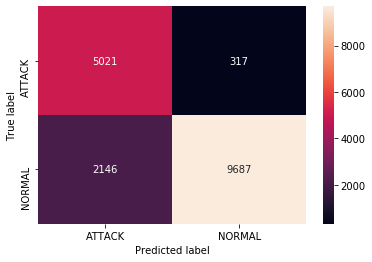

In [222]:
#plt.figure(1 , figsize = (10 , 5))
tree_test_dos = metrics.confusion_matrix( test_pred_dos_Y,
                                 network_test_dos1_Y,
                                 [1,0] )
sns.heatmap(tree_test_dos, annot=True,
         fmt='.0f',
         xticklabels = ["ATTACK", "NORMAL"] , yticklabels = ["ATTACK", "NORMAL"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [223]:
print(metrics.classification_report(network_test_dos1_Y, test_pred_dos_Y))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     10004
           1       0.94      0.70      0.80      7167

    accuracy                           0.86     17171
   macro avg       0.88      0.83      0.85     17171
weighted avg       0.87      0.86      0.85     17171



In [ ]:
tree_dos.best_score_

### PROBE

In [226]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV

In [227]:
param_grid = {'max_depth': np.arange(3, 12),
             'max_features': np.arange(5,15)}

In [228]:
tree_probe = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 8, scoring='roc_auc')
tree_probe.fit( probe1_X, network_train_probe1_Y )

GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                         'max_features': array([ 5,  

In [230]:
probe1_X.shape

(78999, 120)

In [231]:
tree_probe.best_score_

0.9986471850083679

In [234]:
tree_probe.best_params_

{'max_depth': 10, 'max_features': 13}

In [235]:
metrics.roc_auc_score(network_train_probe1_Y, pd.DataFrame(tree_probe.predict_proba(probe1_X))[1])

0.9998504191365013

In [236]:
train_pred_probe = tree_probe.predict(probe1_X)

In [239]:
train_pred_probe

array([0, 0, 0, ..., 0, 0, 0])

In [240]:
print(metrics.classification_report(network_train_probe1_Y, train_pred_probe))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67343
           1       0.99      1.00      0.99     11656

    accuracy                           1.00     78999
   macro avg       0.99      1.00      1.00     78999
weighted avg       1.00      1.00      1.00     78999



In [241]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 15.0, 'Predicted label')

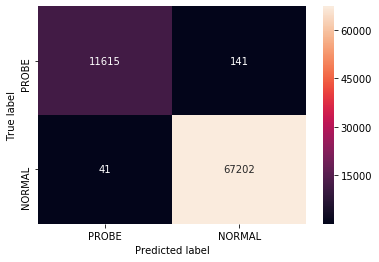

In [242]:
#plt.figure(1 , figsize = (10 , 5))
tree_cm_probe = metrics.confusion_matrix( train_pred_probe,
                                 network_train_probe1_Y,
                                 [1,0] )

sns.heatmap(tree_cm_probe, annot=True,
         fmt='.0f',
         xticklabels = ["PROBE", "NORMAL"] , yticklabels = ["PROBE", "NORMAL"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [243]:
clf_tree_probe = DecisionTreeClassifier( max_depth =10, max_features=13 )
clf_tree_probe.fit( probe1_X, network_train_probe1_Y )

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=13, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [244]:
clf_tree_probe.feature_importances_

array([3.87088519e-03, 1.29546639e-03, 8.92415894e-02, 2.38288565e-03,
       3.79204930e-03, 9.00376578e-03, 2.71140747e-01, 8.60177565e-04,
       1.06872991e-04, 2.95032068e-01, 8.70489665e-03, 1.13609551e-01,
       1.87846759e-03, 4.91759287e-04, 7.31841084e-06, 7.40811556e-04,
       0.00000000e+00, 0.00000000e+00, 6.05854462e-04, 2.08032957e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.97432740e-06, 0.00000000e+00, 0.00000000e+00,
       2.70605028e-02, 5.25196434e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.84383521e-05, 0.00000000e+00, 1.25750540e-04,
       0.00000000e+00, 5.52438377e-03, 1.45326825e-04, 2.62390998e-04,
       0.00000000e+00, 4.09541013e-03, 2.49122493e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.21952875e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [245]:
var_imp_probe = pd.concat([pd.Series(network_train_probe1_X.columns), pd.Series(clf_tree_probe.feature_importances_)], axis=1)
var_imp_probe.columns = ['feature', 'importance']

In [247]:
var_imp_probe.sort_values('importance', ascending=False).iloc[0:13].reset_index(drop=True)

,feature,importance
0,DST_HOST_SRV_COUNT,0.295
1,DST_HOST_SAME_SRC_PORT_RATE,0.271
2,SRC_BYTES,0.138
3,DST_HOST_SRV_RERROR_RATE,0.114
4,DST_BYTES,0.089
5,LAST_FLAG,0.027
6,SRV_RERROR_RATE,0.011
7,DST_HOST_RERROR_RATE,0.009
8,DST_HOST_SRV_DIFF_HOST_RATE,0.009
9,PROTOCOL_TYPE_tcp,0.006


In [248]:
PROBE_sel_features=var_imp_probe.sort_values('importance', ascending=False).iloc[0:13].reset_index(drop=True).feature.tolist()

In [249]:
PROBE_sel_features

['DST_HOST_SRV_COUNT',
 'DST_HOST_SAME_SRC_PORT_RATE',
 'SRC_BYTES',
 'DST_HOST_SRV_RERROR_RATE',
 'DST_BYTES',
 'LAST_FLAG',
 'SRV_RERROR_RATE',
 'DST_HOST_RERROR_RATE',
 'DST_HOST_SRV_DIFF_HOST_RATE',
 'PROTOCOL_TYPE_tcp',
 'SAME_SRV_RATE',
 'COUNT',
 'DST_HOST_DIFF_SRV_RATE']

#### Test

In [250]:
test_pred_probe_Y = clf_tree_probe.predict(probe1_test_X)

In [251]:
test_pred_probe_Y

array([0, 1, 0, ..., 0, 0, 0])

Text(0.5, 15.0, 'Predicted label')

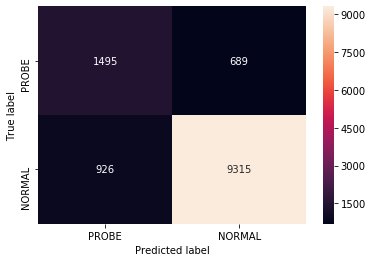

In [252]:
#plt.figure(1 , figsize = (10 , 5))
tree_test_probe = metrics.confusion_matrix( test_pred_probe_Y,
                                 network_test_probe1_Y,
                                 [1,0] )
sns.heatmap(tree_test_probe, annot=True,
         fmt='.0f',
         xticklabels = ["PROBE", "NORMAL"] , yticklabels = ["PROBE", "NORMAL"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [253]:
print(metrics.classification_report(network_test_probe1_Y, test_pred_probe_Y))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     10004
           1       0.68      0.62      0.65      2421

    accuracy                           0.87     12425
   macro avg       0.80      0.77      0.78     12425
weighted avg       0.87      0.87      0.87     12425



### R2L

In [255]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV

In [256]:
param_grid = {'max_depth': np.arange(3, 12),
             'max_features': np.arange(5,15)}

In [257]:
tree_r2l = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 8, scoring='roc_auc')
tree_r2l.fit( r2l1_X, network_train_r2l1_Y )

GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                         'max_features': array([ 5,  

In [258]:
r2l1_X.shape

(68338, 120)

In [259]:
tree_r2l.best_score_

0.9932311042086924

In [260]:
tree_r2l.best_params_

{'max_depth': 9, 'max_features': 13}

In [261]:
metrics.roc_auc_score(network_train_r2l1_Y, pd.DataFrame(tree_r2l.predict_proba(r2l1_X))[1])

0.999837485394094

In [268]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [274]:
clf_tree_r2l = DecisionTreeClassifier( max_depth =10, max_features=13 )
clf_tree_r2l.fit( r2l1_X, network_train_r2l1_Y )

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=13, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [275]:
train_pred_r2l = clf_tree_r2l.predict(r2l1_X)

Text(0.5, 15.0, 'Predicted label')

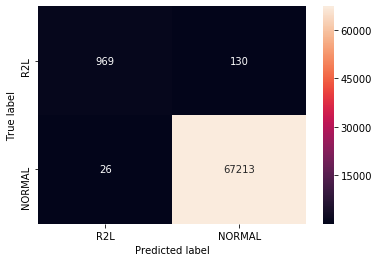

In [276]:
#plt.figure(1 , figsize = (10 , 5))
tree_cm_r2l = metrics.confusion_matrix( train_pred_r2l,
                                 network_train_r2l1_Y,
                                 [1,0] )

sns.heatmap(tree_cm_r2l, annot=True,
         fmt='.0f',
         xticklabels = ["R2L", "NORMAL"] , yticklabels = ["R2L", "NORMAL"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [277]:
print(metrics.classification_report(network_train_r2l1_Y, train_pred_r2l))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67343
           1       0.88      0.97      0.93       995

    accuracy                           1.00     68338
   macro avg       0.94      0.99      0.96     68338
weighted avg       1.00      1.00      1.00     68338



In [278]:
clf_tree_r2l.feature_importances_

array([9.98316240e-05, 5.00684064e-06, 3.99116288e-02, 4.38768287e-03,
       6.67343133e-02, 4.41565730e-02, 1.17368431e-01, 5.19864592e-02,
       1.71828831e-04, 2.33988042e-03, 4.89451943e-04, 0.00000000e+00,
       1.52934016e-02, 2.13543930e-02, 0.00000000e+00, 1.97864987e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.55453893e-04,
       2.04864862e-05, 0.00000000e+00, 1.35419768e-02, 0.00000000e+00,
       2.14360775e-03, 9.35624293e-02, 0.00000000e+00, 0.00000000e+00,
       4.00588776e-01, 1.62288830e-03, 1.19200806e-03, 0.00000000e+00,
       1.75127812e-03, 0.00000000e+00, 0.00000000e+00, 1.89466363e-02,
       0.00000000e+00, 9.18939458e-05, 0.00000000e+00, 0.00000000e+00,
       9.73552347e-04, 8.81771236e-03, 9.61809121e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.14793519e-08, 0.00000000e+00,
      

In [279]:
var_imp_r2l = pd.concat([pd.Series(network_train_r2l1_X.columns), pd.Series(clf_tree_r2l.feature_importances_)], axis=1)
var_imp_r2l.columns = ['feature', 'importance']

In [281]:
var_imp_r2l.sort_values('importance', ascending=False).iloc[0:13].reset_index(drop=True)

,feature,importance
0,LAST_FLAG,0.401
1,DST_HOST_SAME_SRC_PORT_RATE,0.117
2,IS_GUEST_LOGIN,0.094
3,DST_HOST_DIFF_SRV_RATE,0.067
4,DST_HOST_SAME_SRV_RATE,0.052
5,SRC_BYTES,0.050
6,DST_HOST_RERROR_RATE,0.044
7,DST_BYTES,0.040
8,DURATION,0.021
9,FLAG_RSTO,0.020


In [282]:
R2L_sel_features=var_imp_r2l.sort_values('importance', ascending=False).iloc[0:13].reset_index(drop=True).feature.tolist()

In [283]:
R2L_sel_features

['LAST_FLAG',
 'DST_HOST_SAME_SRC_PORT_RATE',
 'IS_GUEST_LOGIN',
 'DST_HOST_DIFF_SRV_RATE',
 'DST_HOST_SAME_SRV_RATE',
 'SRC_BYTES',
 'DST_HOST_RERROR_RATE',
 'DST_BYTES',
 'DURATION',
 'FLAG_RSTO',
 'NUM_ROOT',
 'DST_HOST_SRV_SERROR_RATE',
 'SERVICE_ftp_data']

#### Test

In [284]:
test_pred_r2l_Y = clf_tree_r2l.predict(r2l1_test_X)

In [285]:
test_pred_r2l_Y

array([0, 0, 0, ..., 0, 0, 0])

Text(0.5, 15.0, 'Predicted label')

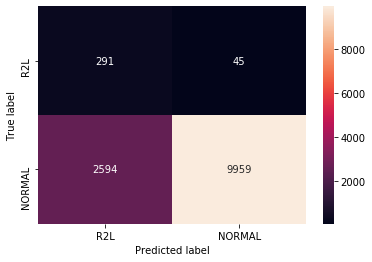

In [286]:
#plt.figure(1 , figsize = (10 , 5))
tree_test_r2l = metrics.confusion_matrix( test_pred_r2l_Y,
                                 network_test_r2l1_Y,
                                 [1,0] )
sns.heatmap(tree_test_r2l, annot=True,
         fmt='.0f',
         xticklabels = ["R2L", "NORMAL"] , yticklabels = ["R2L", "NORMAL"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [287]:
print(metrics.classification_report(network_test_r2l1_Y, test_pred_r2l_Y))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88     10004
           1       0.87      0.10      0.18      2885

    accuracy                           0.80     12889
   macro avg       0.83      0.55      0.53     12889
weighted avg       0.81      0.80      0.73     12889



### U2R

In [288]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV

In [289]:
param_grid = {'max_depth': np.arange(3, 12),
             'max_features': np.arange(5,15)}

In [339]:
tree_u2r = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 8, scoring='roc_auc')
tree_u2r.fit( u2r1_X, network_train_u2r1_Y )

GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                         'max_features': array([ 5,  

In [340]:
u2r1_X.shape

(134686, 120)

In [341]:
tree_u2r.best_score_

0.9997871384826402

In [342]:
tree_u2r.best_params_

{'max_depth': 11, 'max_features': 10}

In [343]:
metrics.roc_auc_score(network_train_u2r1_Y, pd.DataFrame(tree_u2r.predict_proba(u2r1_X))[1])

0.999515563745284

In [344]:
clf_tree_u2r = DecisionTreeClassifier( max_depth =11, max_features=10 )
clf_tree_u2r.fit( u2r1_X, network_train_u2r1_Y )

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
                       max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [345]:
clf_tree_u2r.feature_importances_

array([1.27656267e-02, 9.45986317e-07, 8.86342198e-04, 7.12377936e-04,
       1.06539079e-03, 2.86469406e-04, 0.00000000e+00, 1.24965202e-03,
       2.07515864e-04, 8.53260727e-02, 2.07774747e-04, 0.00000000e+00,
       5.41305218e-04, 9.24865958e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.85336436e-03, 0.00000000e+00,
       3.32052977e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.05890375e-03, 0.00000000e+00, 0.00000000e+00, 1.93810845e-01,
       0.00000000e+00, 2.80336142e-01, 0.00000000e+00, 4.11879928e-04,
       0.00000000e+00, 0.00000000e+00, 4.14186924e-03, 2.96655173e-05,
       5.95692603e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [346]:
train_pred_u2r = clf_tree_u2r.predict(u2r1_X)

In [347]:
train_pred_u2r

array([0, 0, 0, ..., 1, 1, 1])

In [348]:
print(metrics.classification_report(network_train_u2r1_Y, train_pred_u2r))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67343
           1       1.00      1.00      1.00     67343

    accuracy                           1.00    134686
   macro avg       1.00      1.00      1.00    134686
weighted avg       1.00      1.00      1.00    134686



In [349]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 15.0, 'Predicted label')

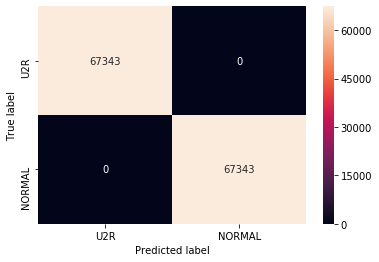

In [350]:
#plt.figure(1 , figsize = (10 , 5))
tree_cm_u2r = metrics.confusion_matrix( train_pred_u2r,
                                 network_train_u2r1_Y,
                                 [1,0] )

sns.heatmap(tree_cm_u2r, annot=True,
         fmt='.0f',
         xticklabels = ["U2R", "NORMAL"] , yticklabels = ["U2R", "NORMAL"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [351]:
var_imp_u2r = pd.concat([pd.Series(network_train_u2r1_X.columns), pd.Series(clf_tree_u2r.feature_importances_)], axis=1)
var_imp_u2r.columns = ['feature', 'importance']

In [353]:
var_imp_u2r.sort_values('importance', ascending=False).iloc[0:10].reset_index(drop=True)

,feature,importance
0,NUM_FILE_CREATIONS,0.280
1,NUM_COMPROMISED,0.194
2,SERVICE_ftp_data,0.168
3,SRC_BYTES,0.129
4,DURATION,0.092
5,DST_HOST_SRV_COUNT,0.085
6,SERVICE_telnet,0.023
7,COUNT,0.013
8,PROTOCOL_TYPE_udp,0.004
9,LAST_FLAG,0.003


In [354]:
U2R_sel_features=var_imp_u2r.sort_values('importance', ascending=False).iloc[0:10].reset_index(drop=True).feature.tolist()

#### Test

In [355]:
test_pred_u2r_Y = clf_tree_u2r.predict(u2r1_test_X)

In [356]:
test_pred_u2r_Y

array([0, 0, 0, ..., 0, 0, 0])

Text(0.5, 15.0, 'Predicted label')

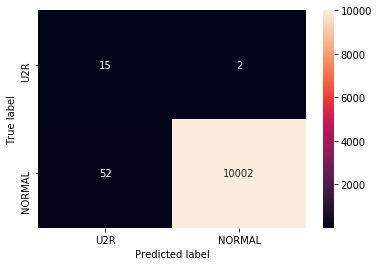

In [357]:
#plt.figure(1 , figsize = (10 , 5))
tree_test_u2r = metrics.confusion_matrix( test_pred_u2r_Y,
                                 network_test_u2r1_Y,
                                 [1,0] )
sns.heatmap(tree_test_u2r, annot=True,
         fmt='.0f',
         xticklabels = ["U2R", "NORMAL"] , yticklabels = ["U2R", "NORMAL"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [358]:
print(metrics.classification_report(network_test_u2r1_Y, test_pred_u2r_Y))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10004
           1       0.88      0.22      0.36        67

    accuracy                           0.99     10071
   macro avg       0.94      0.61      0.68     10071
weighted avg       0.99      0.99      0.99     10071

